# Run lunar lander - DQN

### Author: lyds 
***

Here we train our `ActionBot` using a deep Q learning approach

In [1]:
import sys
sys.path.append("..")

In [2]:
import gym
from uuid import uuid4
import os
import datetime
import numpy as np
from collections import deque

from src.episode_memory import EpisodeMemory
from src.replay_memory import ReplayMemory
from src.action_bot import DQNActionBot
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%load_ext watermark

%watermark -u -n -t
%watermark -iv -v

last updated: Wed Dec 04 2019 17:53:38
matplotlib 3.0.3
numpy      1.16.2
gym        0.12.0
CPython 3.6.8
IPython 7.2.0


#### Set up training parameters
***

In [5]:
env_name = "LunarLander-v2"
total_episodes = 2500
max_time_steps = 512
env_seed = None
unique_run = None # "8529a77d-e192-4adc-922e-b432e2f2d7a2"

load = False
save = True
rendering = False
replay = False

In [6]:
if unique_run is None:
    unique_run = uuid4()

#### Instantiate objects
***

In [7]:
if total_episodes < 1:
    raise ValueError("Cannot have number of episodes less than 1")

env = gym.make(env_name)
best_memory = EpisodeMemory(env_name)
best_memory.total_reward = -np.inf

reward_vals = []
reward_window = deque(maxlen=100)

replay_memory = ReplayMemory()

action_bot = DQNActionBot(env)
if load:
    action_bot.load_dqn_weights(unique_run)

#### Train
***

We train using a Q-learning approach.

In [12]:
%%time
converged = False
print("Starting training...")
for episode_number in range(total_episodes):
    
    # record memories
    episode_memory = EpisodeMemory(env_name)
    if env_seed is not None:
        episode_memory.seed = env_seed
    env.seed(episode_memory.seed)
    
    # set up episode run
    obs = env.reset()
    done = False
    t = 0

    while not done and t <= max_time_steps:
        if rendering:
            env.render()
        
        # get action
        action_bot.obs = obs
        action_bot.episode_n = episode_number
        action = action_bot.get_dq_action()
        new_obs, reward, done, _ = env.step(action)
        action_bot.next_obs = new_obs

        episode_memory.update(action, reward)
        experiences, learn = replay_memory.update(
            obs, action, reward, new_obs, done, episode_number
        )
        if learn:
            action_bot.learn(experiences)
        obs = new_obs
        t += 1

    env.close()

    if episode_number % 100 == 0 and episode_number > 0:
        print(
            f"Rolling average reward for episode:{episode_number} = {np.mean(reward_window)}"
        )

    if episode_number > 0 and episode_number % 500 == 0 and save:
        action_bot.save_dqn_weights(unique_run)

    reward_vals.append(episode_memory.total_reward)
    reward_window.append(episode_memory.total_reward)

    if best_memory.total_reward < episode_memory.total_reward:
        best_memory = episode_memory

    if np.mean(reward_window) > 200:
        converged = True
        print(f"Converged after {episode_number} episodes.")
        break

print(f"Highest total reward = {best_memory.total_reward}")
print(f"Average total reward = {sum(reward_vals) / total_episodes}")

if save:
    action_bot.save_dqn_weights(unique_run)

    logging_file = "../training_history/logging.txt"
    if not os.path.isfile(logging_file):
        with open(logging_file, "a") as logs:
            logs.write(
                "Date, Run number, Converged, Episodes to complete, Average reward\n"
            )

    with open(logging_file, "a") as logs:
        logs.write(
            f"{datetime.datetime.now().isoformat()}, "
            f"{unique_run}, "
            f"{converged}, "
            f"{episode_number + 1}, "
            f"{np.mean(reward_window)}\n"
        )

Starting training...
Rolling average reward for episode:100 = -295.3468957344673
Rolling average reward for episode:200 = -110.78523213333561
Rolling average reward for episode:300 = -41.301872710491125
Rolling average reward for episode:400 = -38.14911995014423
Rolling average reward for episode:500 = -32.54872501266843
Saved DQN weights!
Rolling average reward for episode:600 = -0.38961910316656023
Rolling average reward for episode:700 = 18.186960228504564
Rolling average reward for episode:800 = 33.731313131497465
Rolling average reward for episode:900 = 42.50526344204755
Rolling average reward for episode:1000 = 31.084332055215135
Saved DQN weights!
Rolling average reward for episode:1100 = 23.226499443843267
Rolling average reward for episode:1200 = 14.987258446995032
Rolling average reward for episode:1300 = 52.80940574220378
Rolling average reward for episode:1400 = 12.698015985531569
Rolling average reward for episode:1500 = 116.50154471984351
Saved DQN weights!
Rolling averag

Plot the training history with a rolling mean

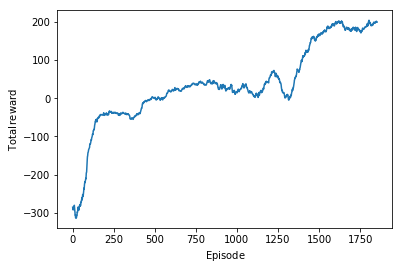

In [13]:
N = 75
plt.plot(np.convolve(reward_vals, np.ones((N,))/N, mode='valid'))
plt.xlabel(r"$\mathrm{Episode}$")
plt.ylabel(r"$\mathrm{Total \/ reward}$")
plt.show()

Show the best episode that we experienced

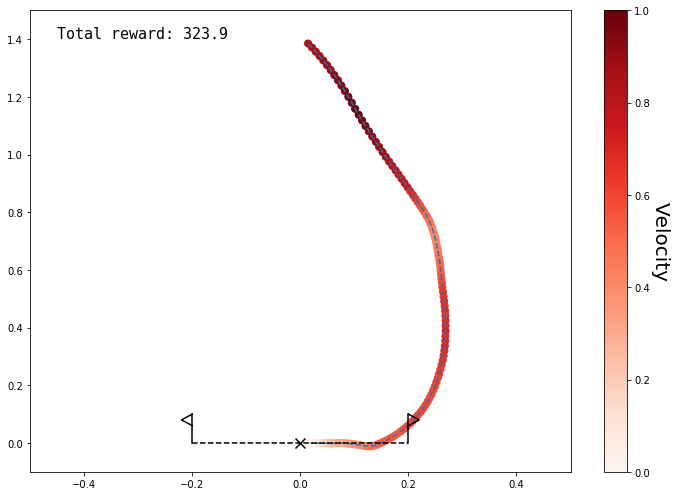

In [15]:
best_memory.replay(True)

#### Demo the model
***
Load in a model with fitted weights and run an episode


Loaded DQN weights!


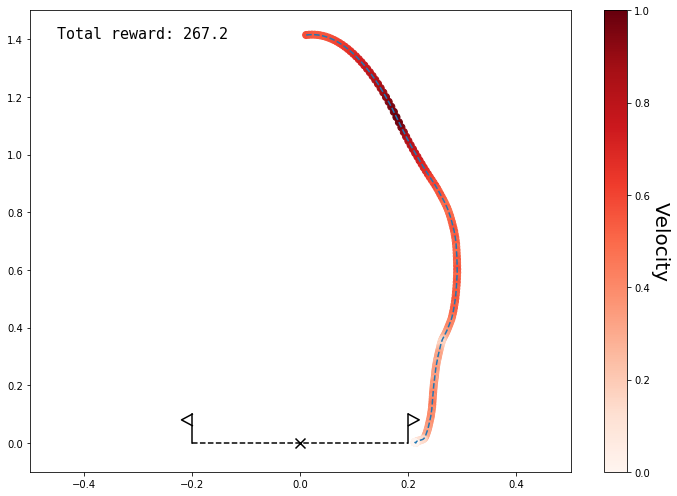

Total reward for memory: 267.21


In [16]:
env = gym.make(env_name)
action_bot = DQNActionBot(env)
unique_run = "1f46aa2c-6e2d-4b71-af7c-28243ecddb10"
action_bot.load_dqn_weights(unique_run)
action_bot.demo = True

# set up episode run
episode_memory = EpisodeMemory(env_name)
if env_seed is not None:
    episode_memory.seed = env_seed
env.seed(episode_memory.seed)
obs = env.reset()
done = False
t = 0

while not done and t <= max_time_steps:
    # get action
    action_bot.obs = obs
    action_bot.episode_n = 1
    action = action_bot.get_dq_action()
    # update action bot
    new_obs, reward, done, _ = env.step(action)   
    episode_memory.update(action, reward)
    obs = new_obs
    t += 1
    
episode_memory.replay(True)
print(f"Total reward for memory: {episode_memory.total_reward:.2f}")